In [ ]:
#| default_exp models.softs

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

# SOFTS

SOFTS (Series-cOre Fused Time Series) incorporates the novel STar Aggregate-Dispatch (STAD) module. Instead of leearning channel interactions through a distributed architecture, like attention, the STAD module employs a centralized strategy where series are aggregated to form a global core representation, while maintaning linear complexity.

**References**
- [Lu Han, Xu-Yang Chen, Han-Jia Ye, De-Chuan Zhan. "SOFTS: Efficient Multivariate Time Series Forecasting with Series-Core Fusion"](https://arxiv.org/pdf/2404.14197)

![Figure 1. Architecture of SOFTS.](imgs_models/softs_architecture.png)

In [ ]:
#| export

import torch
import torch.nn as nn
import torch.nn.functional as F

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_multivariate import BaseMultivariate
from neuralforecast.common._modules import TransEncoder, TransEncoderLayer

## 1. Auxiliary functions
### 1.1 Embedding

In [ ]:
#| exporti

class DataEmbedding_inverted(nn.Module):
    def __init__(self, c_in, d_model, dropout=0.1):
        super(DataEmbedding_inverted, self).__init__()
        self.value_embedding = nn.Linear(c_in, d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = x.permute(0, 2, 1)
        # x: [Batch Variate Time]
        if x_mark is None:
            x = self.value_embedding(x)
        else:
            # the potential to take covariates (e.g. timestamps) as tokens
            x = self.value_embedding(torch.cat([x, x_mark.permute(0, 2, 1)], 1))
        # x: [Batch Variate d_model]
        return self.dropout(x)

### 1.2 STAD (STar Aggregate Dispatch)

In [ ]:
#| exporti

class STAD(nn.Module):
    def __init__(self, d_series, d_core):
        super(STAD, self).__init__()
        """
        STar Aggregate Dispatch Module
        """

        self.gen1 = nn.Linear(d_series, d_series)
        self.gen2 = nn.Linear(d_series, d_core)
        self.gen3 = nn.Linear(d_series + d_core, d_series)
        self.gen4 = nn.Linear(d_series, d_series)

    def forward(self, input, *args, **kwargs):
        batch_size, channels, d_series = input.shape

        # set FFN
        combined_mean = F.gelu(self.gen1(input))
        combined_mean = self.gen2(combined_mean)

        # stochastic pooling
        if self.training:
            ratio = F.softmax(combined_mean, dim=1)
            ratio = ratio.permute(0, 2, 1)
            ratio = ratio.reshape(-1, channels)
            indices = torch.multinomial(ratio, 1)
            indices = indices.view(batch_size, -1, 1).permute(0, 2, 1)
            combined_mean = torch.gather(combined_mean, 1, indices)
            combined_mean = combined_mean.repeat(1, channels, 1)
        else:
            weight = F.softmax(combined_mean, dim=1)
            combined_mean = torch.sum(combined_mean * weight, dim=1, keepdim=True).repeat(1, channels, 1)

        # mlp fusion
        combined_mean_cat = torch.cat([input, combined_mean], -1)
        combined_mean_cat = F.gelu(self.gen3(combined_mean_cat))
        combined_mean_cat = self.gen4(combined_mean_cat)
        output = combined_mean_cat

        return output, None

## 2. Model

In [ ]:
#| export

class SOFTS(BaseMultivariate):

    """ SOFTS
    
    **Parameters:**<br>
    `h`: int, Forecast horizon. <br>
    `input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
    `n_series`: int, number of time-series.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `hidden_size`: int, dimension of the model.<br>
    `d_core`: int, dimension of core in STAD.<br>
    `e_layers`: int, number of encoder layers.<br>
    `d_ff`: int, dimension of fully-connected layer.<br>
    `dropout`: float, dropout rate.<br>
    `use_norm`: bool, whether to normalize or not.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
    `lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>
    
    **References**<br>
    [Lu Han, Xu-Yang Chen, Han-Jia Ye, De-Chuan Zhan. "SOFTS: Efficient Multivariate Time Series Forecasting with Series-Core Fusion"](https://arxiv.org/pdf/2404.14197)
    """

    # Class attributes
    SAMPLING_TYPE = 'multivariate'
    EXOGENOUS_FUTR = False
    EXOGENOUS_HIST = False
    EXOGENOUS_STAT = False

    def __init__(self,
                 h,
                 input_size,
                 n_series,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 hidden_size: int = 512,
                 d_core: int = 512,
                 e_layers: int = 2,
                 d_ff: int = 2048,
                 dropout: float = 0.1,
                 use_norm: bool = True,
                 loss = MAE(),
                 valid_loss = None,
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = -1,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 step_size: int = 1,
                 scaler_type: str = 'identity',
                 random_seed: int = 1,
                 num_workers_loader: int = 0,
                 drop_last_loader: bool = False,
                 optimizer = None,
                 optimizer_kwargs = None,
                 lr_scheduler = None,
                 lr_scheduler_kwargs = None,            
                 **trainer_kwargs):
        
        super(SOFTS, self).__init__(h=h,
                                    input_size=input_size,
                                    n_series=n_series,
                                    stat_exog_list = None,
                                    futr_exog_list = None,
                                    hist_exog_list = None,
                                    loss=loss,
                                    valid_loss=valid_loss,
                                    max_steps=max_steps,
                                    learning_rate=learning_rate,
                                    num_lr_decays=num_lr_decays,
                                    early_stop_patience_steps=early_stop_patience_steps,
                                    val_check_steps=val_check_steps,
                                    batch_size=batch_size,
                                    step_size=step_size,
                                    scaler_type=scaler_type,
                                    random_seed=random_seed,
                                    num_workers_loader=num_workers_loader,
                                    drop_last_loader=drop_last_loader,
                                    optimizer=optimizer,
                                    optimizer_kwargs=optimizer_kwargs,
                                    lr_scheduler=lr_scheduler,
                                    lr_scheduler_kwargs=lr_scheduler_kwargs,
                                    **trainer_kwargs)
        
        self.h = h
        self.enc_in = n_series
        self.dec_in = n_series
        self.c_out = n_series
        self.use_norm = use_norm

        # Architecture
        self.enc_embedding = DataEmbedding_inverted(input_size, 
                                                    hidden_size, 
                                                    dropout)
        
        self.encoder = TransEncoder(
            [
                TransEncoderLayer(
                    STAD(hidden_size, d_core),
                    hidden_size,
                    d_ff,
                    dropout=dropout,
                    activation=F.gelu
                ) for l in range(e_layers)
            ]
        )

        self.projection = nn.Linear(hidden_size, self.h, bias=True)

    def forecast(self, x_enc):
        # Normalization from Non-stationary Transformer
        if self.use_norm:
            means = x_enc.mean(1, keepdim=True).detach()
            x_enc = x_enc - means
            stdev = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
            x_enc /= stdev

        _, _, N = x_enc.shape
        enc_out = self.enc_embedding(x_enc, None)
        enc_out, attns = self.encoder(enc_out, attn_mask=None)
        dec_out = self.projection(enc_out).permute(0, 2, 1)[:, :, :N]

        # De-Normalization from Non-stationary Transformer
        if self.use_norm:
            dec_out = dec_out * (stdev[:, 0, :].unsqueeze(1).repeat(1, self.h, 1))
            dec_out = dec_out + (means[:, 0, :].unsqueeze(1).repeat(1, self.h, 1))
        return dec_out
    
    def forward(self, windows_batch):
        insample_y = windows_batch['insample_y']

        y_pred = self.forecast(insample_y)
        y_pred = y_pred[:, -self.h:, :]
        y_pred = self.loss.domain_map(y_pred)

        # domain_map might have squeezed the last dimension in case n_series == 1
        if y_pred.ndim == 2:
            return y_pred.unsqueeze(-1)
        else:
            return y_pred

In [ ]:
show_doc(SOFTS)

---

### SOFTS

>      SOFTS (h, input_size, n_series, futr_exog_list=None, hist_exog_list=None,
>             stat_exog_list=None, hidden_size:int=512, d_core:int=512,
>             e_layers:int=2, d_ff:int=2048, dropout:float=0.1,
>             use_norm:bool=True, loss=MAE(), valid_loss=None,
>             max_steps:int=1000, learning_rate:float=0.001,
>             num_lr_decays:int=-1, early_stop_patience_steps:int=-1,
>             val_check_steps:int=100, batch_size:int=32, step_size:int=1,
>             scaler_type:str='identity', random_seed:int=1,
>             num_workers_loader:int=0, drop_last_loader:bool=False,
>             optimizer=None, optimizer_kwargs=None, lr_scheduler=None,
>             lr_scheduler_kwargs=None, **trainer_kwargs)

SOFTS

**Parameters:**<br>
`h`: int, Forecast horizon. <br>
`input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
`n_series`: int, number of time-series.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`hidden_size`: int, dimension of the model.<br>
`d_core`: int, dimension of core in STAD.<br>
`e_layers`: int, number of encoder layers.<br>
`d_ff`: int, dimension of fully-connected layer.<br>
`dropout`: float, dropout rate.<br>
`use_norm`: bool, whether to normalize or not.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of different series in each batch.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int=1, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
`optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
`lr_scheduler`: Subclass of 'torch.optim.lr_scheduler.LRScheduler', optional, user specified lr_scheduler instead of the default choice (StepLR).<br>
`lr_scheduler_kwargs`: dict, optional, list of parameters used by the user specified `lr_scheduler`.<br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>

**References**<br>
[Lu Han, Xu-Yang Chen, Han-Jia Ye, De-Chuan Zhan. "SOFTS: Efficient Multivariate Time Series Forecasting with Series-Core Fusion"](https://arxiv.org/pdf/2404.14197)

In [ ]:
show_doc(SOFTS.fit, name='SOFTS.fit')

---

### SOFTS.fit

>      SOFTS.fit (dataset, val_size=0, test_size=0, random_seed=None,
>                 distributed_config=None)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [ ]:
show_doc(SOFTS.predict, name='SOFTS.predict')

---

### SOFTS.predict

>      SOFTS.predict (dataset, test_size=None, step_size=1, random_seed=None,
>                     **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

## 3. Usage example

In [ ]:
#| eval: false

import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic
from neuralforecast.losses.pytorch import MSE

In [ ]:
#| eval: false

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = SOFTS(h=12,
              input_size=24,
              n_series=2,
              hidden_size=256,
              d_core=256,
              e_layers=2,
              d_ff=64,
              dropout=0.1,
              use_norm=True,
              loss=MSE(),
              valid_loss=MAE(),
              early_stop_patience_steps=3,
              batch_size=32)

fcst = NeuralForecast(models=[model], freq='M')
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params
---------------------------------------------------------
0 | loss          | MSE                    | 0     
1 | valid_loss    | MAE                    | 0     
2 | padder        | ConstantPad1d          | 0     
3 | scaler        | TemporalNorm           | 0     
4 | enc_embedding | DataEmbedding_inverted | 6.4 K 
5 | encoder       | TransEncoder           | 725 K 
6 | projection    | Linear                 | 3.1 K 
---------------------------------------------------------
735 K     Trainable params
0         Non-trainable params
735 K     Total params
2.940     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/marcopeix/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/neuralforecast/core.py:201: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


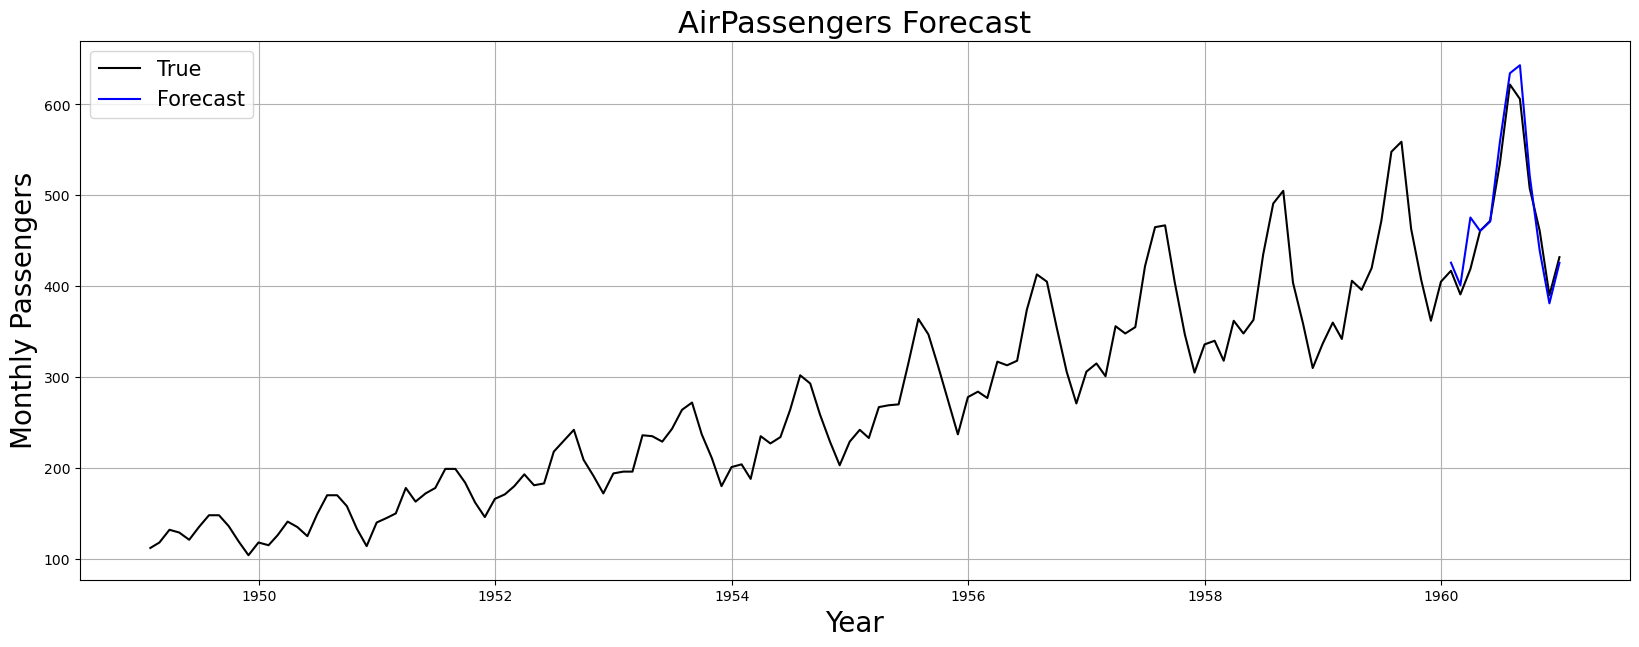

In [ ]:
#| eval: false

# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['SOFTS'], c='blue', label='Forecast')
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Year', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [ ]:
#| eval: false

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = SOFTS(h=12,
              input_size=24,
              n_series=1,
              hidden_size=256,
              d_core=256,
              e_layers=2,
              d_ff=64,
              dropout=0.1,
              use_norm=True,
              loss=MSE(),
              valid_loss=MAE(),
              early_stop_patience_steps=3,
              batch_size=32)

fcst = NeuralForecast(models=[model], freq='M')
fcst.fit(df=Y_train_df, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                   | Params
---------------------------------------------------------
0 | loss          | MSE                    | 0     
1 | valid_loss    | MAE                    | 0     
2 | padder        | ConstantPad1d          | 0     
3 | scaler        | TemporalNorm           | 0     
4 | enc_embedding | DataEmbedding_inverted | 6.4 K 
5 | encoder       | TransEncoder           | 725 K 
6 | projection    | Linear                 | 3.1 K 
---------------------------------------------------------
735 K     Trainable params
0         Non-trainable params
735 K     Total params
2.940     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Users/marcopeix/miniconda3/envs/neuralforecast/lib/python3.10/site-packages/neuralforecast/core.py:201: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
